# Import the data

In [2]:
import os
from scipy.io import loadmat
import numpy as np
np.random.seed(10)
from sklearn.preprocessing import MinMaxScaler
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64) 
    new_file = filename.replace('.mat','.hea') 
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

def import_key_data(path):
    gender = []
    age = []
    labels = []
    datas = []
    ecg_filenames = []
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".mat"):
                # Check if corresponding .hea file exists
                hea_filepath = filepath.replace('.mat', '.hea')
                if not os.path.exists(hea_filepath):
                    continue  # Skip this .mat file if .hea doesn't exist

                data, header_data = load_challenge_data(filepath)
                x = data[:, :4000]
                scaler = MinMaxScaler()
                x = scaler.fit_transform(x.T).T
                datas.append(x)
                labels.append(header_data[15][6:-1])
                ecg_filenames.append(filepath)
                gender.append(header_data[14][7:-1])
                age.append(header_data[13][7:-1])

    return gender, age, labels, ecg_filenames, datas

In [3]:
gender, age, labels, ecg_filenames, datas = import_key_data("/kaggle/input/ecgdataset/cpsc_2018")
gender_extra, age_extra, labels_extra, ecg_filenames_extra, datas_extra = import_key_data("/kaggle/input/cpsc-2018-extra/cpsc_2018_extra")
# gender_ptb, age_ptb, labels_ptb, ecg_filenames_ptb, datas_ptb = import_key_data("/kaggle/input/test-data/ningbo")


print(len(datas))
print(len(datas_extra))
# print(len(datas_ningbo))

6877
3453


In [ ]:
# for ningbo data
quarter_length = len(datas_ningbo) // 2
datas_ningbo = datas_ningbo[:quarter_length]

In [ ]:
# for ningbo data
quarter_length = len(datas_ptb) // 2
datas_ptb = datas_ptb[:quarter_length]

# Analysis the data - gender and age

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Gender Ratio: {'Male': 0.5364956437560503, 'Female': 0.46350435624394964}


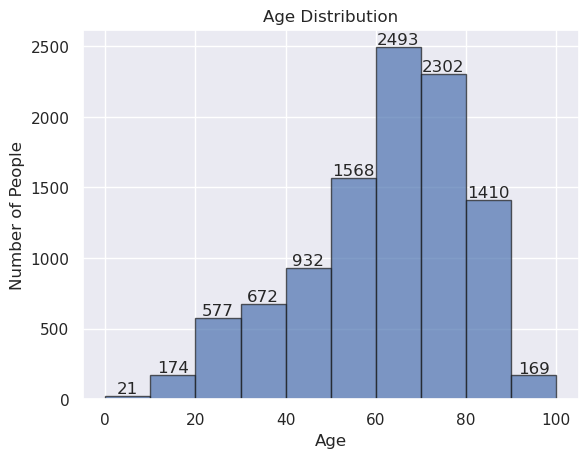

In [6]:
import numpy as np
from collections import Counter

# Combine the main and extra datasets for gender and age
combined_genders = gender + gender_extra
combined_ages = age + age_extra

# 1. Count and calculate gender ratio
gender_counts = Counter(combined_genders)
total_gender = len(combined_genders)
gender_ratio = {k: v / total_gender for k, v in gender_counts.items()}

print("Gender Ratio:", gender_ratio)

valid_ages = [int(a) for a in combined_ages if a.isdigit()]
age_counts = Counter(valid_ages)
counts, bins, patches = plt.hist(valid_ages, bins=range(0, 110, 10), edgecolor="k", alpha=0.7)

# Label each bin with count
for bin_count, bin_left, patch in zip(counts, bins, patches):
    height = patch.get_height()
    # Place text at the top of the bar
    plt.text(bin_left + 5, height + 50, int(bin_count), 
             ha='center', va='center')

plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of People")
plt.show()

# Combine two datasets

In [7]:
# combine two dataset
datas_total = datas+datas_extra
labels_total = labels+labels_extra

# for one dataset test
# datas_total = datas
# labels_total = labels

# Choose labels

In [8]:
import pandas as pd

# count the number of labels
label_series = pd.Series(labels_total)
label_count = label_series.value_counts().head(10)

# print top 10 labels
print(label_count)

# get the top 7 labels
choose_labels = label_count.head(7).index.tolist()
print(choose_labels)

59118001     1533
164889003     976
426783006     918
429622005     794
270492004     689
164884008     607
428750005     545
284470004     535
164867002     428
164930006     290
dtype: int64
['59118001', '164889003', '426783006', '429622005', '270492004', '164884008', '428750005']


# Delete the data whose the length is less than 4000 or other length

In [9]:
import numpy as np

inconsistent_lengths = []
for idx, arr in enumerate(datas_total):
    arr_np = np.array(arr)
    if idx > 0 and arr_np.shape != np.array(datas_total[idx - 1]).shape:
        inconsistent_lengths.append(idx)
print(inconsistent_lengths)

[5959, 5960]


In [10]:
index_to_remove = inconsistent_lengths
for idx in sorted(index_to_remove, reverse=True): 
    if idx < len(datas_total):
        datas_total.pop(idx)
    else:
        print(f"Index {idx} is out of range of datas_total")
        
    if idx < len(labels_total):
        labels_total.pop(idx)
    else:
        print(f"Index {idx} is out of range of labels_total")

In [11]:
# filter the corresponding data
indices = [i for i, label in enumerate(labels_total) if label in choose_labels]
data = np.asarray([datas_total[i] for i in indices])
labels = np.asarray([labels_total[i] for i in indices])

# One Hot Encoder labels

In [12]:
from sklearn.preprocessing import OneHotEncoder

labels = OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1, 1))
labels

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [13]:
# check labels shape
labels.shape

(6060, 7)

In [14]:
# reshape the data
data = data.reshape(data.shape[0], data.shape[2], data.shape[1])

In [15]:
# check data shape
data.shape

(6060, 4000, 12)

# Split the data as train, test and valiation

In [16]:
from sklearn.model_selection import train_test_split
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [24]:
# for validation
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Define the attention layer

In [17]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer

class Attention(Layer):

    def __init__(self, units=128, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        
        self.attention_score_vec = Dense(input_dim, use_bias=False, name='attention_score_vec')
        self.h_t = Lambda(lambda x: x[:, -1, :], output_shape=(input_dim,), name='last_hidden_state')
        self.attention_score = Dot(axes=[1, 2], name='attention_score')
        self.attention_weight = Activation('softmax', name='attention_weight')
        self.context_vector = Dot(axes=[1, 1], name='context_vector')
        self.attention_output = Concatenate(name='attention_output')
        self.attention_vector = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')

        super().build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def call(self, inputs, **kwargs):
        score_first_part = self.attention_score_vec(inputs)
        h_t = self.h_t(inputs)
        score = self.attention_score([h_t, score_first_part])
        attention_weights = self.attention_weight(score)
        
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.context_vector([inputs, attention_weights])
        pre_activation = self.attention_output([context_vector, h_t])
        attention_vector = self.attention_vector(pre_activation)
        
        return attention_vector

    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units})
        return config

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Define evaluation classification

In [18]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

def evaluate_classification(y_test, y_pred):
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1-score': f1_score(y_test, y_pred, average='macro')
    }
    
    print(classification_report(y_test, y_pred))
    
    return metrics

# Define confusion matrix

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_test, X_test=None, model=None, y_pred=None, label_names=None, show_percent=True, file_prefix=None):
    """
    Params:
     - y_test: true labels.
     - X_test: test data, only used when passing in the model.
     - model: the trained model.
     - y_pred: predicted label.
     - label_names: label names.
     - show_percent: Whether to show the percentage in the confusion matrix.
     - file_prefix: The saved file prefix.
    """
    
    fig, ax = plt.subplots(figsize=(8, 7))
    values_format = '.2%' if show_percent else '.0f'
    normalize = 'true' if show_percent else None

    if model:
        title = f"{type(model).__name__} - Confusion Matrix"
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax, values_format=values_format, 
                                              cmap='YlGnBu', normalize=normalize, display_labels=label_names)
    elif y_pred is not None:
        title = "Confusion Matrix"
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, values_format=values_format, 
                                                cmap='YlGnBu', normalize=normalize, display_labels=label_names)
    else:
        raise ValueError("Either 'model' or 'y_pred' should be provided.")

    ax.set_title(title)
    ax.grid(False)
    filename = f"{file_prefix or ''}{title}.jpg"
    plt.savefig(filename, dpi=400)
    plt.show()

# Define train model

In [20]:
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

def train_model(model, X_train, y_train, X_val, y_val, model_name='Model', epochs=5, batch_size=128):
    # Plot and save model architecture
    plot_model(model, to_file=f"{model_name}.jpg", show_shapes=True, show_layer_names=True)

    # Define the ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1)
    
    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        callbacks=[reduce_lr])

    # Get model predictions on validation data
    y_pred = model.predict(X_val).argmax(axis=1)
    y_true = y_val.argmax(axis=1)

    # Evaluate the model using custom evaluation function
    metrics = {}
    metrics = evaluate_classification(y_true, y_pred)

    # Plot the confusion matrix
    if 'plot_Confusion_Matrix' in globals():
        plot_Confusion_Matrix(model=None, X_test=None, y_test=y_true, y_pred=y_pred, 
                              label_names=None, show_percent=False, file_prefix=model_name)
    
    return model, metrics, history

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional, Conv1D, MaxPooling1D, AveragePooling1D

def create_CNN_BiLSTM_Attention_model(input_shape, output_units, 
                                      units=64, activation='relu', optimizer='adam'):
    """
    Create a CNN-BiLSTM-Attention architecture model.
    """
    model = Sequential()
    
    # Conv1D Layers
    model.add(Conv1D(units, 3, 2, input_shape=input_shape, activation=activation))
    model.add(AveragePooling1D(pool_size=1))
    for _ in range(5):
        model.add(Conv1D(units, 3, 2, activation=activation))
        model.add(MaxPooling1D(pool_size=1))
    
    # BiLSTM Layer
    model.add(Bidirectional(LSTM(units, activation=activation, return_sequences=True), merge_mode='concat'))
    model.add(Dropout(0.5))
    
    # Attention Layer
    model.add(Attention(units))
    model.add(Dense(128))
    model.add(Dense(output_units, activation='softmax', name='Output'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
output_units = y_train.shape[1]
model = create_CNN_BiLSTM_Attention_model(input_shape, output_units)
print(model.summary())

model, metrics, history = train_model(model, X_train, y_train, X_test, y_test, model_name='Model', epochs=40)
print(metrics)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1999, 64)          2368      
                                                                 
 average_pooling1d (AverageP  (None, 1999, 64)         0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 999, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 999, 64)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 499, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 499, 64)          0

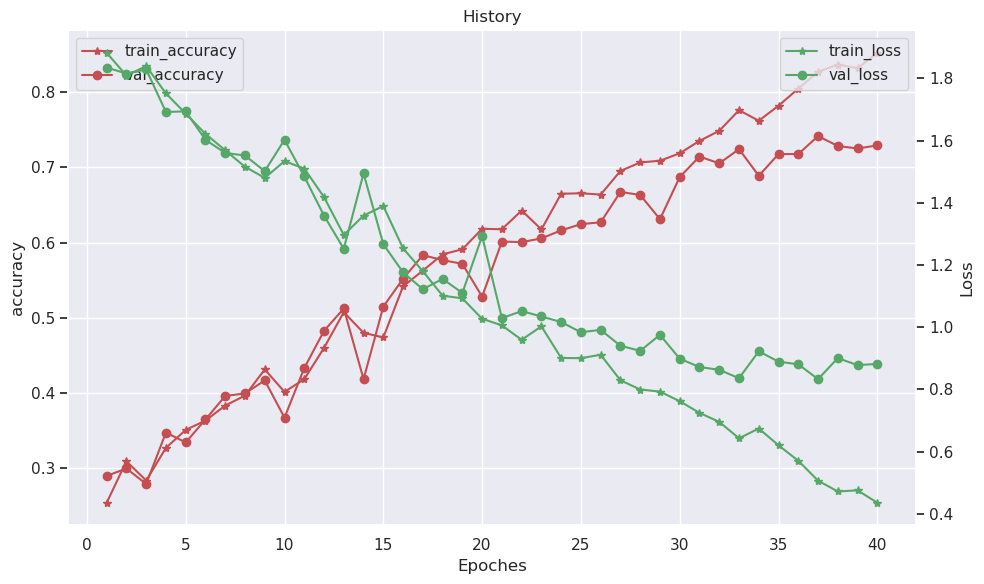

In [22]:
def plot_training_history(history,metric = 'accuracy'):
    """
    plot training history for keras/tensorflow/pytorch model
    history = model.fit(....)
    Plot the accuracy vs epoch, and loss vs epoch for training and validation data.
    """
    import matplotlib.pyplot as plt
    if type(history) is not dict:
        history = history.history
    assert type(history) is dict
    if 'train_loss' not in history.keys():
        history['train_loss'] = history['loss']
    if f'train_{metric}' not in history.keys():
        history[f'train_{metric}'] = history[metric]
    loss = history['train_loss']
    acc = history[f'train_{metric}']
    val_loss = history['val_loss']
    val_acc = history[f'val_{metric}']

    x_epoch = list(range(1,len(loss)+1))
    # plot the figure
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1,1,1)
    ax2 = ax1.twinx()
    ax1.plot(x_epoch,acc,'r-*',label = f'train_{metric}')
    ax2.plot(x_epoch,loss,'g-*',label = 'train_loss')
    ax1.plot(x_epoch,val_acc,'r-o',label = f'val_{metric}')
    ax2.plot(x_epoch,val_loss,'g-o',label = 'val_loss')
    ax1.legend(loc = 2)
    ax2.legend(loc = 1)
    ax1.set_ylabel(metric)
    ax2.set_ylabel('Loss')
    ax1.set_xlabel('Epoches')
    plt.grid(False)
    plt.title("History")
    plt.tight_layout()
    plt.show()

plot_training_history(history,metric='accuracy')

# Test the model

In [25]:
input_shape = (X_train.shape[1], X_train.shape[2])
output_units = y_train.shape[1]
model = create_CNN_BiLSTM_Attention_model(input_shape, output_units)
print(model.summary())

model, metrics, history = train_model(model, X_train, y_train, X_val, y_val, model_name='Model', epochs=40)
print(metrics)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1999, 64)          2368      
                                                                 
 average_pooling1d_1 (Averag  (None, 1999, 64)         0         
 ePooling1D)                                                     
                                                                 
 conv1d_7 (Conv1D)           (None, 999, 64)           12352     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 999, 64)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 499, 64)           12352     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 499, 64)         

In [26]:
# for test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

38/38 [==============================] - 2s 55ms/step - loss: 0.8156 - accuracy: 0.7583
Test Loss: 0.8156002163887024
Test Accuracy: 0.7582508325576782


38/38 [==============================] - 2s 55ms/step
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       122
           1       0.86      0.85      0.86       196
           2       0.75      0.77      0.76       150
           3       0.74      0.71      0.73       195
           4       0.67      0.52      0.59       115
           5       0.61      0.65      0.63       156
           6       0.85      0.91      0.88       278

    accuracy                           0.76      1212
   macro avg       0.74      0.73      0.73      1212
weighted avg       0.76      0.76      0.76      1212



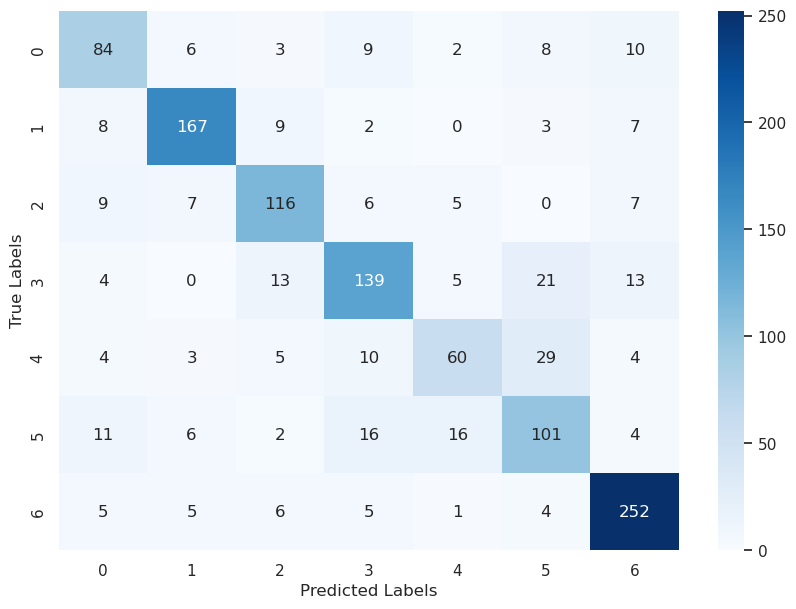

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
test_loss, test_accuracy = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Classification report
print(classification_report(y_true, y_pred))

# Confusion matrix heatmap
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()